In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame, read_csv

# model used for feature importances
import lightgbm as lgb

# utility for early stopping with a validation set
from sklearn.model_selection import train_test_split

# memory management
import gc

In [2]:
Location = r'../data/data.csv'
data = pd.read_csv(Location)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14549 entries, 0 to 14548
Columns: 1686 entries, MSISDN to WEEKEND_HOLYDAY_P14_USED_INTERNET
dtypes: float64(1667), int64(11), object(8)
memory usage: 187.1+ MB


In [3]:
labels = data['AGE']
# print(labels[0:5])
data_x = data.drop('AGE', axis = 1)
# print(data_x.columns.size)
base_features = data_x.columns
base_features[0:5]

Index(['MSISDN', 'STATUS', 'GENDER', 'CLIENT_AGING', 'CLIENT_VALUE'], dtype='object')

In [4]:
"""
Referenced by https://towardsdatascience.com/a-feature-selection-tool-for-machine-learning-in-python-b64dd23710f0
"""
#Identify features whose number of NAN is bigger than threshold
def identify_missing(data, missing_threshold):
    #Calculate fraction of missing in each column
    missing_series = data.isnull().sum() / data.shape[0]
    #Create dataframe for missing features
    missing_stats = pd.DataFrame(missing_series).rename(columns = {'index': 'feature', 0: 'missing_fraction'})
    #Sorted them by descending order of missing fraction
    missing_stats = missing_stats.sort_values('missing_fraction',ascending = False)
    #Filter those has 
    record_missing = pd.DataFrame(missing_series[missing_series > missing_threshold]).reset_index().rename(columns = {'index':'feature',
                                                                                                              0:'missing_fraction'})
    # Find the columns with a missing percentage above the threshold
    record_missing = pd.DataFrame(missing_series[missing_series > 0.98]).reset_index().rename(columns = {'index': 'feature', 
                                                                                                     0: 'missing_fraction'})
    to_drop=list(record_missing['feature'])
    data = data.drop(to_drop, axis = 1)
    return data
                                                                                
                                                                                                              

In [5]:
#Identify features with single unique value, NAN is not included
def identify_single_unique(data):
    #Calculate unique count in each column
    unique_counts = data.nunique()
    unique_stats  = pd.DataFrame(unique_counts).rename(columns = {'index': 'feature', 0: 'nunique'})
    unique_stats = unique_stats.sort_values('nunique', ascending = True)
    # Find the columns with only one unique count
    record_single_unique = pd.DataFrame(unique_counts[unique_counts == 1]).reset_index().rename(columns = {'index': 'feature',0: 'nunique'})
    # record_single_unique
    to_drop=list(record_single_unique['feature'])
#     print(len(to_drop1))
    data = data.drop(to_drop,axis = 1)
#     print(data.columns.size)
    return data

In [6]:
#Identify colinear feature
"""
        Finds collinear features based on the correlation coefficient between features. 
        For each pair of features with a correlation coefficient greather than `correlation_threshold`,
        only one of the pair is identified for removal. 
"""
def identify_collinear(data, correlation_threshold, one_hot = False):
    if one_hot:
        #One hot encoding
        features = pd.get_dummies(data)
        one_hot_features = []
        for column in features.columns:
            if column not in base_features:
                one_hot_features.append(column)
#         print(len(one_hot_features))
        data = pd.concat([features[one_hot_features],data],axis = 1)
        corr_matrix = pd.get_dummies(features).corr()
    else:
        corr_matrix = data.corr()
     # Extract the upper triangle of the correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))
    # Select the features with correlations above the threshold
    # Need to use the absolute value
    to_drop = [column for column in upper.columns if any(upper[column].abs() > correlation_threshold)]
    # Dataframe to hold correlated pairs
    record_collinear = pd.DataFrame(columns = ['drop_feature', 'corr_feature', 'corr_value'])
    # Iterate through the columns to drop to record pairs of correlated features
    for column in to_drop:

    # Find the correlated features
        corr_features = list(upper.index[upper[column].abs() > correlation_threshold])

        # Find the correlated values
        corr_values = list(upper[column][upper[column].abs() > correlation_threshold])
        drop_features = [column for _ in range(len(corr_features))]    

        # Record the information (need a temp df for now)
        temp_df = pd.DataFrame.from_dict({'drop_feature': drop_features,
                                            'corr_feature': corr_features,
                                            'corr_value': corr_values})

    # Add to dataframe
        record_collinear = record_collinear.append(temp_df, ignore_index = True)
    data = data.drop(to_drop,axis = 1)
    return data

In [7]:
#Identify zero importance feature
def identify_zero_importance(data, eval_metric, n_iterations, early_stopping):
    if early_stopping and eval_metric is None:
            raise ValueError("""eval metric must be provided with early stopping. Examples include "auc" for classification or
                             "l2" for regression.""")
    if data.columns is None:
        raise ValueError("No training label provided.")
    
    #One-hot encoding
    data = pd.get_dummies(data)
    # Extract feature names
    feature_names = list(data.columns)
    #Convert dummy features to np array
    features = np.array(data)
    # print(features[0:5,:])
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    print('Training Gradient Boosting Model\n')

#     n_iterations=10
#     early_stopping = True
#     eval_metric = 'auc'
    for _ in range(n_iterations):
        model = lgb.LGBMRegressor(n_estimators=1000, learning_rate = 0.05, verbose = -1)
    
        # If training using early stopping need a validation set
        if early_stopping:
            train_features, valid_features, train_labels, valid_labels = train_test_split(features, labels, 
                                                                                          test_size = 0.15)
        
            # Train the model with early stopping
            model.fit(train_features, train_labels, eval_metric = eval_metric,
                        eval_set = [(valid_features, valid_labels)],
                        early_stopping_rounds = 100, verbose = -1)
            # Clean up memory
            gc.enable()
            del train_features, train_labels, valid_features, valid_labels
            gc.collect()
#     print (model.feature_importances_)
        feature_importance_values += model.feature_importances_ / n_iterations
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})

    # Sort features according to importance
    feature_importances = feature_importances.sort_values('importance', ascending = False).reset_index(drop = True)
    # Normalize the feature importances to add up to one
    feature_importances['normalized_importance'] = feature_importances['importance'] / feature_importances['importance'].sum()
    feature_importances['cumulative_importance'] = np.cumsum(feature_importances['normalized_importance'])

    # Extract the features with zero importance
    record_zero_importance = feature_importances[feature_importances['importance'] == 0.0]
    to_drop = list(record_zero_importance['feature'])
#     print(len(to_drop))
    data = data.drop(to_drop, axis = 1)
    feature_importances = feature_importances[feature_importances.importance!=0]
    return data, feature_importances

In [8]:
def identify_low_importance(data, feature_importances, cumulative_importance):
    feature_importances = feature_importances.sort_values('cumulative_importance')
    record_low_importance = feature_importances[feature_importances['cumulative_importance'] > cumulative_importance]
    # # feature_importances
    # # record_low_importance
    to_drop = list(record_low_importance['feature'])
    # # len(to_drop)
    data = data.drop(to_drop, axis = 1)
    return data

In [9]:
data1 = identify_missing(data_x, 0.6)
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14549 entries, 0 to 14548
Columns: 1670 entries, MSISDN to WEEKEND_HOLYDAY_P14_USED_INTERNET
dtypes: float64(1652), int64(10), object(8)
memory usage: 185.4+ MB


In [10]:
data2 = identify_single_unique(data1)
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14549 entries, 0 to 14548
Columns: 1393 entries, MSISDN to WEEKEND_HOLYDAY_P14_USED_INTERNET
dtypes: float64(1380), int64(6), object(7)
memory usage: 154.6+ MB


In [11]:
data3 = identify_collinear(data2, 0.98, False)
data3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14549 entries, 0 to 14548
Columns: 750 entries, MSISDN to WEEKEND_HOLYDAY_P14_USED_SERVICES
dtypes: float64(738), int64(5), object(7)
memory usage: 83.3+ MB


In [12]:
data4,fi = identify_zero_importance(data3, 'auc', 2, True)
data4.info()

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	valid_0's auc: 1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	valid_0's auc: 1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14549 entries, 0 to 14548
Data columns (total 46 columns):
RECHARGE_VALUE                                  11048 non-null float64
AVG_RECHARGE_VALUE                              11048 non-null float64
RECHARGE_AVG                                    11048 non-null float64
MIN_RECHARGE_AVG                                11048 non-null float64
INSTAGRAM_MB                                    11812 non-null float64
SOCIAL_NETWORK_MB_BY_SESSION                    11812 non-null float64
N_DAYS_RECEIVED_CALLS                           11812 non-null float64
AVG_PERC_WHATSAPP_MB                            11812 non-null float64
MAX_PERC_SOCIAL_NETWORK_MB                      118

In [13]:
data5 = identify_low_importance(data4, fi, 0.5)
data5.info

<bound method DataFrame.info of        RECHARGE_VALUE  RECHARGE_AVG  MIN_RECHARGE_AVG  INSTAGRAM_MB  \
0               440.0         62.86             46.67          0.01   
1                50.0         16.67             15.00          0.00   
2               550.0         61.11             50.00          0.02   
3               400.0        100.00            100.00          0.00   
4               410.0         82.00             70.00          0.00   
5               600.0        100.00            100.00          0.00   
6               190.0         47.50             20.00          0.00   
7                 NaN           NaN               NaN          0.00   
8               400.0        100.00            100.00          0.16   
9               550.0         61.11             50.00          0.00   
10              320.0         80.00             73.33          0.00   
11                NaN           NaN               NaN          0.00   
12              650.0         54.17          

In [14]:
data5.isna().sum()

RECHARGE_VALUE                                3501
RECHARGE_AVG                                  3501
MIN_RECHARGE_AVG                              3501
INSTAGRAM_MB                                  2737
P2_MADE_CALLS                                 2798
P2_PERC_DAYS_SOCIAL_NETWORK_OTT               2798
P4_PERC_WHATSAPP_MB                           2837
PERC_INTERNET_SESSIONS_IN_P1                  2737
PERC_RECEIVED_CALLS_DURATION_IN_P2            2737
WEEKDAY_PERC_INTERNET_MB                      2754
WEEKDAY_P23_INSTAGRAM_MB                      2777
WEEKDAY_P23_PERC_WHATSAPP_SESSIONS            2777
WEEKEND_HOLYDAY_P14_PERC_WHATSAPP_MB          3036
WEEKEND_HOLYDAY_P14_PERC_BANK_SESSIONS        3036
WEEKEND_HOLYDAY_P14_WHATSAPP_MB_BY_SESSION    3036
DEVICE_CAPABILITY_2G                             0
dtype: int64

In [19]:
#Drop the row if the row doesnt have all the values or atleast 10% of the values.
data5 = data5.dropna(axis=0,how='all',thresh=len(list(data5))*0.1)

In [20]:
data5.isna().sum()

RECHARGE_VALUE                                778
RECHARGE_AVG                                  778
MIN_RECHARGE_AVG                              778
INSTAGRAM_MB                                   14
P2_MADE_CALLS                                  75
P2_PERC_DAYS_SOCIAL_NETWORK_OTT                75
P4_PERC_WHATSAPP_MB                           114
PERC_INTERNET_SESSIONS_IN_P1                   14
PERC_RECEIVED_CALLS_DURATION_IN_P2             14
WEEKDAY_PERC_INTERNET_MB                       31
WEEKDAY_P23_INSTAGRAM_MB                       54
WEEKDAY_P23_PERC_WHATSAPP_SESSIONS             54
WEEKEND_HOLYDAY_P14_PERC_WHATSAPP_MB          313
WEEKEND_HOLYDAY_P14_PERC_BANK_SESSIONS        313
WEEKEND_HOLYDAY_P14_WHATSAPP_MB_BY_SESSION    313
DEVICE_CAPABILITY_2G                            0
dtype: int64

In [21]:
#Lenght of the data after dropping rows with a lot of Na s
len(data5)

11826

In [24]:
#dumping the preprocessed data into a csv file for later use
data5.to_csv('../data/feature_reduced_data.csv')

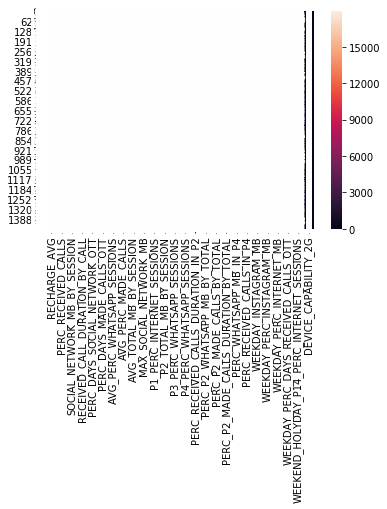

In [30]:
#This takes a long time. Avoid running this section unless necessary
import seaborn as sns
%matplotlib inline

sns.heatmap(data5, annot=True)
